# How to join event data with ECoG data

In [1]:
from IPython.core.display import HTML

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import glob
import sys
import os
from scipy import signal

import paper_utils as paperu

In [2]:
import config_paper as config

hemisphere = config.constants['HEMISPHERES']
patient_ids = config.constants['PATIENT_IDS_PAPER']
decoder_days = config.constants['ECOG_DAYS_PAPER']
DATA_DIR = config.constants['DATA_DIR']
LIMBS = ['r_wrist', 'l_wrist']

F_ECOG = config.constants['F_ECOG']
_MAX_TF_FREQ = config.constants['MAX_TF_FREQ'] # Max Hz for spectrograms
_NPERSEG = config.constants['NPERSEG']
_SCALING = config.constants['SCALING']

In [3]:
print('patient_ids', patient_ids)
print(LIMBS)
print(DATA_DIR)

patient_ids ['a0f66459', 'c95c1e82', 'cb46fd46', 'fcb01f7a', 'ffb52f92', 'b4ac1726', 'f3b79359', 'ec761078', 'f0bbc9a9', 'abdb496b', 'ec168864', 'b45e3f7b']
['r_wrist', 'l_wrist']
/data2/users/satsingh/ST2020_20200602/


## Event data

In [4]:
# Pick a patient & limb
patient_id = patient_ids[0]
limb = LIMBS[0]

# Load event data
events_df = paperu.load_events_for_patient_id(patient_id, limb, rest=True)
events_df = events_df.query("mvmt != 'mv_0'") # remove rest events
events_df.shape

(1513, 42)

In [5]:
events_df.head()

,Unnamed: 0,mvmt,day,event_frame_idx,event_timestamp,time,vid_name,run_01,run_01_conf,run_1_wconf,...,other_lead_overlap30,other_overlap_15pm,other_overlap_30pm,bimanual,ecog_start_idx_mvti,ecog_start_idx_full,ecog_end_idx_mvti,ecog_end_idx_full,patient_id,subject_id
0,0,r_wrist_1,5,570,0 days 07:46:46.171999810,0 days 07:46:46.171999810,a0f66459_8_0000.avi,518,1.000000,0.999997,...,5.0,12.0,29.0,NaN,14002835,14002835,14003334,14003868,a0f66459,S01
1,1,r_wrist_1,5,1534,0 days 07:59:18.849332822,0 days 07:59:18.849332822,a0f66459_8_0006.avi,385,0.999997,0.365284,...,0.0,0.0,0.0,NaN,14379174,14379174,14379673,14380624,a0f66459,S01
2,2,r_wrist_1,5,2648,0 days 07:59:55.982665784,0 days 07:59:55.982665784,a0f66459_8_0006.avi,76,0.004737,0.295038,...,0.0,0.0,0.0,NaN,14397741,14397741,14398240,14399224,a0f66459,S01
3,3,r_wrist_1,5,697,0 days 08:02:51.023333101,0 days 08:02:51.023333101,a0f66459_8_0008.avi,697,NaN,1.000000,...,0.0,0.0,0.0,NaN,14485261,14485261,14485760,14486561,a0f66459,S01
4,4,r_wrist_1,5,839,0 days 08:02:55.756666387,0 days 08:02:55.756666387,a0f66459_8_0008.avi,65,0.999983,0.697463,...,0.0,0.0,0.0,NaN,14487628,14487628,14488127,14489344,a0f66459,S01


## ECoG data 
* Note: this will need MovementInitiationECoG.zip to be downloaded & unzipped

In [6]:
window_before, window_after  = 0.5, 0.5  # seconds
# days = events_df['day'].unique() # All days in event data
# for day in days:

day = 3 # Limit to 1 day for demo
print("Loading data for day", day)

# Get the event time spans
events = events_df[ events_df['day'] == day ]
print(events.shape)
eventspans = paperu.get_eventspans_from_events_ajile(events, window_before, window_after)    

# Get ECoG
cache_prefix = None
cache_prefix = "{}/ecog_mvti_length/{}_{}/".format(DATA_DIR, patient_id, day)
metadata_fname = '{}/ecog_metadata/ecog_metadata_{}.csv'.format(DATA_DIR, patient_id)
metadata_df = pd.read_csv(metadata_fname)
electrode_ids = np.arange(64) # 8 x 8 grid 

# Inspect ECoG metadata
metadata_df.head()

Loading data for day 3
(276, 42)


,Unnamed: 0,SD_channels,Kurt_channels,standardizeDenoms,goodChanInds,X,Y,Z
0,GRID1,35.398535,6.154781,28.978650,0.0,-45.648495,38.560372,36.187962
1,GRID2,55.518727,1.309332,48.247142,1.0,-47.347152,31.182861,41.176799
2,GRID3,33.992008,1.585154,31.077800,1.0,-50.291409,22.157208,45.191885
3,GRID4,33.701261,2.652564,28.651509,1.0,-51.358961,11.787268,48.726509
4,GRID5,59.648470,2.626867,51.301159,1.0,-51.219818,1.713889,53.000981


In [7]:
# Gather ECoG from all 
move_ecog = []
for idx, row in eventspans.iterrows():
    event = row['mvmt']
    start_time = row['start_time']
    end_time = row['end_time']
    ecog_start_idx = row['ecog_start_idx_mvti']
    ecog_end_idx = row['ecog_end_idx_mvti']

    # get_ecog_for_timespan takes care of finding/loading correct ECoG file
    y_ecog_all = paperu.get_ecog_for_timespan(cache_prefix, electrode_ids, 
            ecog_start_idx, ecog_end_idx, metadata_df)
    
    move_ecog.append(y_ecog_all)

In [8]:
# Plot ECoG data for one event
y_ecog_all = move_ecog[0]
ecog_df = pd.DataFrame(y_ecog_all.T) 
ecog_df.shape

(500, 98)

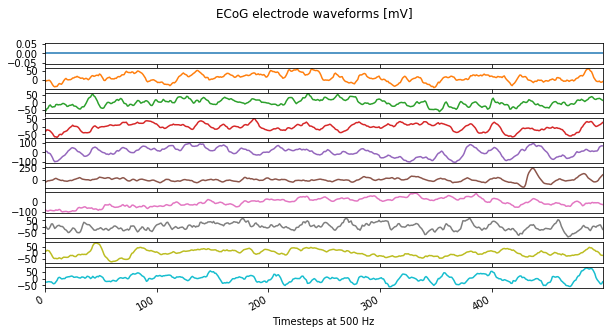

In [14]:
# Plot waveform for first few electrodes
# See manuscript for preprocessing steps carried out on ECoG
axs = ecog_df.iloc[:, :10].plot(subplots=True, 
                                legend=False, 
                                figsize=(10,5),
                                title='ECoG electrode waveforms [mV]'
                               );
plt.xlabel('Timesteps at {} Hz'.format(F_ECOG));